# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/cancer-detection
- Data Source: https://www.kaggle.com/competitions/nlp-getting-started/data (Howard et al., 2019)
- Python version: 3.13

## Data Collection and Provenance ##

"This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website" (Howard et al., 2019). The data represents tweets that may or may not be about a disaster. The training data has been hand-labeled. The data is now offered in relation to a Kaggle competition. The Kaggle competition uses the F1 metric to evaluate success of a submission.

## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **binary classification** deep learning problem. It relies on **natural language processing (NLP)** techniques to convert the tweets to vector data. I will build a **Recurrent Neural Network** deep learning model capable of classifying the tweets in the data set.

**Project Goal:** Build a deep learning model capable of classifying the tweets with **at least 90% validation accuracy**.

## Data Description ##

The dataset contains 7613 labeled tweets. 4342 are non-disaster (label 0), and 3271 are disasters (0). All rows contain text and a target. Almost all (7552) contain keywords, and most (5080) contain location.


# Exploratory Data Analysis #

## Data Loading ##


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


In [16]:
#this downloads resources from nltk (natural language tool kit) that we will need later
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sean.pritchard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sean.pritchard/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sean.pritchard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sean.pritchard/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sean.pritchard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_df = pd.read_csv('data/train.csv')
train_df[90:100]

,id,keyword,location,text,target
90,132,accident,NaN,???? it was an accident http://t.co/Oia5fxi4gM,0
91,133,accident,"New Hanover County, NC",FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;WPD;160...,1
92,134,accident,NaN,8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY a...,1
93,135,accident,global,Aashiqui Actress Anu Aggarwal On Her Near-Fata...,1
94,136,accident,Alberta | Sask. | Montana,Suffield Alberta Accident https://t.co/bPTmlF4P10,1
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0
99,143,accident,NaN,only had a car for not even a week and got in ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Data Exploration ##

I will examine the class distribution, keyword distribution, and create wordclouds for the positive and negative labels.


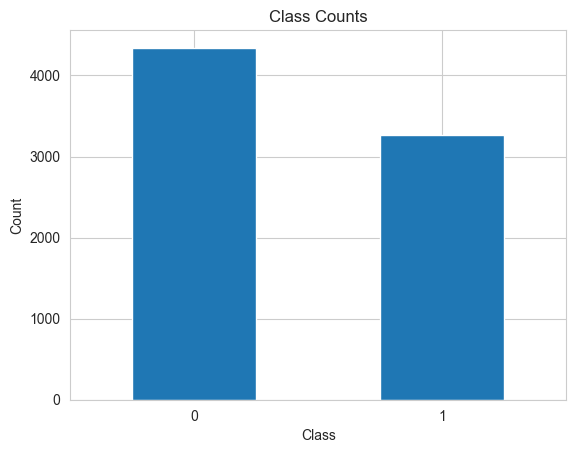

In [11]:
class_counts = train_df['target'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [32]:
class_counts.head()

target
0    4342
1    3271
Name: count, dtype: int64

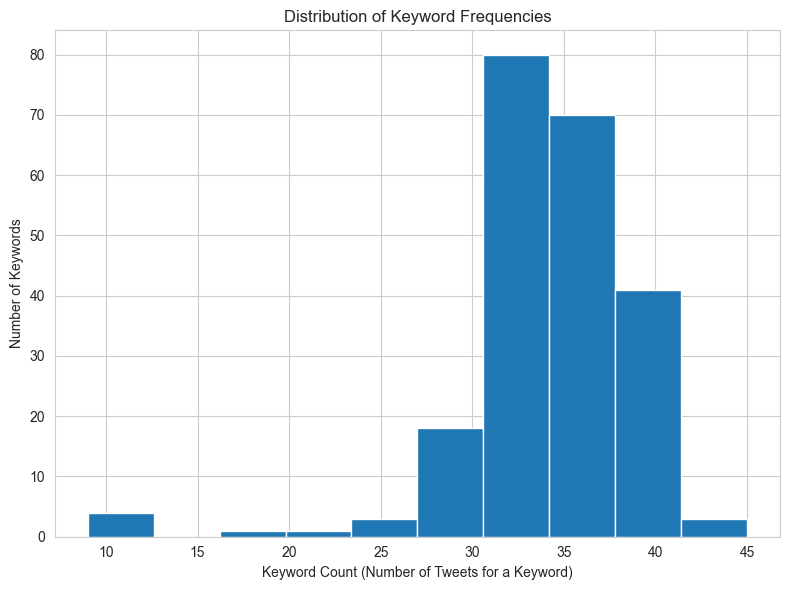

In [15]:
keyword_counts = train_df['keyword'].value_counts()
keyword_counts.hist(figsize=(8, 6))
plt.title('Distribution of Keyword Frequencies')
plt.xlabel('Keyword Count (Number of Tweets for a Keyword)')
plt.ylabel('Number of Keywords')
plt.tight_layout()
plt.show()

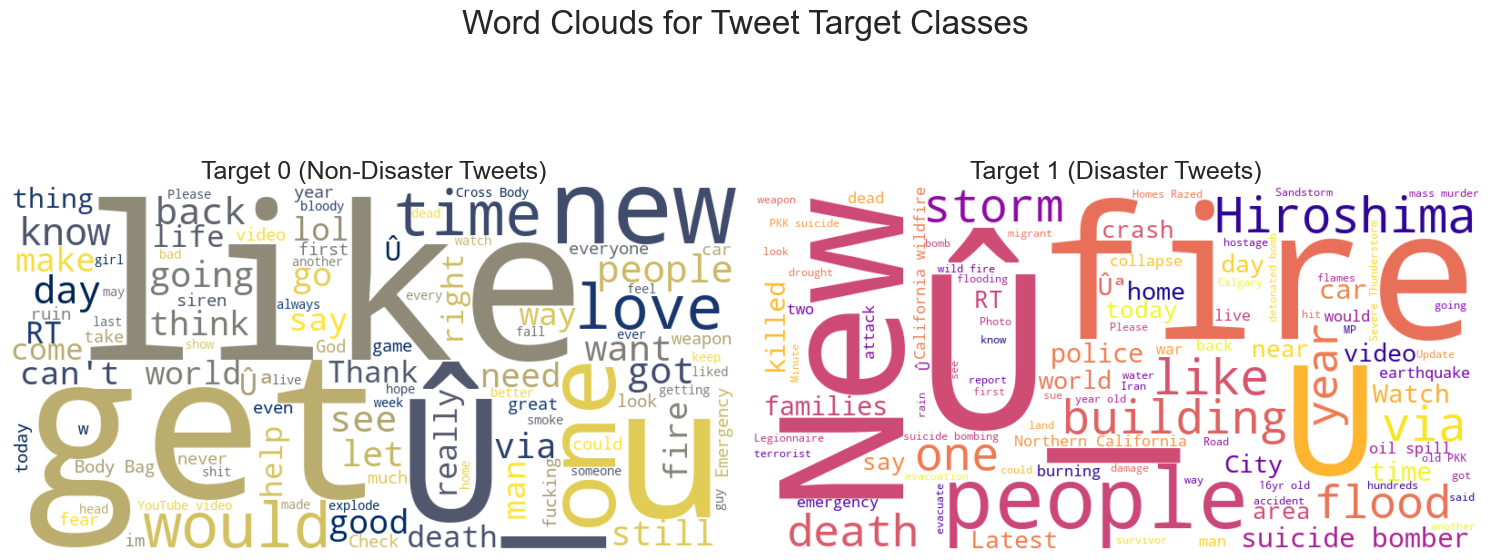

In [31]:
from wordcloud import WordCloud

# combine stopwords and punctuation
nltk_stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation)
custom_stopwords = nltk_stopwords.union(set(" "))
#adding a few noise words that I see in the initial attempts at wordclouds
custom_stopwords.add('http')
custom_stopwords.add('https')
custom_stopwords.add('co')
custom_stopwords.add('amp')


def exract_text_for_target(dataframe, target_value):
    """Filters the DataFrame and returns a single string of combined text."""
    # Filter by target
    df_filtered = dataframe[dataframe['target'] == target_value]

    # Combine all text into a single string, filling any NaN with an empty string
    combined_text = ' '.join(df_filtered['text'].astype(str).tolist())
    return combined_text

# Generate combined text for target 0 (non-disaster) and target 1 (disaster)
text_target_0 = exract_text_for_target(train_df, 0)
text_target_1 = exract_text_for_target(train_df, 1)


def create_wordcloud(text, title, colormap_name):
    """Creates a WordCloud object."""
    # Initialize the WordCloud object with desired parameters
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        min_font_size=10,
        max_words=100,
        colormap=colormap_name
    ).generate(text)
    return wordcloud

# Create word clouds with distinct colors
wc_0 = create_wordcloud(text_target_0, 'Target 0 (Non-Disaster)', 'cividis')
wc_1 = create_wordcloud(text_target_1, 'Target 1 (Disaster)', 'plasma')

plt.figure(figsize=(15, 7))

# Plot Word Cloud for Target 0
plt.subplot(1, 2, 1)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title('Target 0 (Non-Disaster Tweets)', fontsize=18)

# Plot Word Cloud for Target 1
plt.subplot(1, 2, 2)
plt.imshow(wc_1, interpolation='bilinear')
plt.axis("off")
plt.title('Target 1 (Disaster Tweets)', fontsize=18)

plt.suptitle('Word Clouds for Tweet Target Classes', fontsize=24)
plt.tight_layout()
plt.show()

# Plan of Analysis #

**Data Cleaning**
- Because a small number of tweets lack the keyword, I will drop those from the data set.
- I will drop location becuase only 66% of the tweets contain location. This incomplete data may distract the model
- I will remove stop words and puctuation as I did when making the wordclouds.

**Data Preparation and Vectorization**
Because this project requires the use of RNN, it is critical to maintain word order when converting the text to vectors. Approaches such as word counts and TF-IDF are more focused on frequency than sequence, and so are unsuitable. I will use GloVe:

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. (Pennington et al., 2014)

I will use GloVe both because it maintains the word sequence that is critical for RNN, but also because a pre-trained corpus trained on tweets is available. It is reasonable to expect that the model trained on tweets will perform well on this data set of tweets.

**Model Training and Hyperparameter Tuning**
I will then conduct training and hyperparameter tuning on three models. I will use a basic RNN model, LSTM, and GRU.

## Data Cleaning ##


# Citations #

- Howard, A., devrishi, Culliton, P., & Guo, Y. (2019). Natural language processing with disaster tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started
- Pennington, J., Socher, R., & Manning, C. D. (2014). GloVe: Global Vectors for Word Representation. Stanford NLP. https://nlp.stanford.edu/projects/glove/